In [1]:
using LowLevelFEM
import LowLevelFEM as FEM

gmsh.initialize()

In [2]:
using SparseArrays, LinearAlgebra

In [3]:
gmsh.open("body2.geo")

Info    : Reading 'body2.geo'...
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 10%] Meshing curve 2 (Line)
Info    : [ 20%] Meshing curve 3 (Line)
Info    : [ 30%] Meshing curve 4 (Line)
Info    : [ 40%] Meshing curve 5 (Line)
Info    : [ 50%] Meshing curve 6 (Line)
Info    : [ 60%] Meshing curve 7 (Line)
Info    : [ 60%] Meshing curve 8 (Line)
Info    : [ 70%] Meshing curve 9 (Line)
Info    : [ 80%] Meshing curve 10 (Line)
Info    : [ 90%] Meshing curve 11 (Line)
Info    : [100%] Meshing curve 12 (Line)
Info    : Done meshing 1D (Wall 0.000652852s, CPU 0.000654s)
Info    : Meshing 2D...
Info    : [  0%] Meshing surface 1 (Transfinite)
Info    : [ 20%] Meshing surface 2 (Transfinite)
Info    : [ 40%] Meshing surface 3 (Transfinite)
Info    : [ 60%] Meshing surface 4 (Transfinite)
Info    : [ 70%] Meshing surface 5 (Transfinite)
Info    : [ 90%] Meshing surface 6 (Transfinite)
Info    : Done meshing 2D (Wall 0.000230266s, CPU 0.000231s)
Info    : Meshing 3D

In [4]:
λ = 1
μ = 2

2

In [5]:
#mat = FEM.material("body", E=μ * (3λ + 2μ) / (λ + μ), ν=λ / 2 / (λ + μ))
mat = FEM.material("body", E=10, ν=0.3)
problem = FEM.Problem([mat])

Info    : RCMK renumbering...
Info    : Done RCMK renumbering (bandwidth is now 61)


LowLevelFEM.Problem("body2", :Solid, 3, 3, LowLevelFEM.Material[LowLevelFEM.Material("body", 10.0, 0.3, 7.85e-9, 45.0, 4.2e8, 1.2e-5, 5.769230769230768, 3.846153846153846, 8.333333333333334)], 1.0, 275)

In [6]:
field = FEM.field("body", f=2)
sc = FEM.ScalarField(problem, [field])

LowLevelFEM.ScalarField([[2.0; 2.0; … ; 2.0; 2.0;;], [2.0; 2.0; … ; 2.0; 2.0;;], [2.0; 2.0; … ; 2.0; 2.0;;], [2.0; 2.0; … ; 2.0; 2.0;;], [2.0; 2.0; … ; 2.0; 2.0;;], [2.0; 2.0; … ; 2.0; 2.0;;], [2.0; 2.0; … ; 2.0; 2.0;;], [2.0; 2.0; … ; 2.0; 2.0;;], [2.0; 2.0; … ; 2.0; 2.0;;], [2.0; 2.0; … ; 2.0; 2.0;;]  …  [2.0; 2.0; … ; 2.0; 2.0;;], [2.0; 2.0; … ; 2.0; 2.0;;], [2.0; 2.0; … ; 2.0; 2.0;;], [2.0; 2.0; … ; 2.0; 2.0;;], [2.0; 2.0; … ; 2.0; 2.0;;], [2.0; 2.0; … ; 2.0; 2.0;;], [2.0; 2.0; … ; 2.0; 2.0;;], [2.0; 2.0; … ; 2.0; 2.0;;], [2.0; 2.0; … ; 2.0; 2.0;;], [2.0; 2.0; … ; 2.0; 2.0;;]], Matrix{Float64}(undef, 0, 0), [273, 274, 275, 276, 277, 278, 279, 280, 281, 282  …  423, 424, 425, 426, 427, 428, 429, 430, 431, 432], 1, :scalarInElements)

In [7]:
r0 = FEM.nodePositionVector(problem)
F = FEM.deformationGradient(problem, r0)

LowLevelFEM.TensorField([[1.0; 0.0; … ; 0.0; 1.0;;], [1.0; 0.0; … ; 0.0; 1.0;;], [1.0; 0.0; … ; 0.0; 1.0;;], [1.0; 0.0; … ; 0.0; 1.0;;], [1.0; 0.0; … ; 0.0; 1.0;;], [1.0; 0.0; … ; 0.0; 1.0;;], [1.0; 0.0; … ; 0.0; 1.0;;], [1.0; 0.0; … ; 0.0; 1.0;;], [1.0; 0.0; … ; 0.0; 1.0;;], [1.0; 0.0; … ; 0.0; 1.0;;]  …  [1.0; 0.0; … ; 0.0; 1.0;;], [1.0; 0.0; … ; 0.0; 1.0;;], [1.0; 0.0; … ; 0.0; 1.0;;], [1.0; 0.0; … ; 0.0; 1.0;;], [1.0; 0.0; … ; 0.0; 1.0;;], [1.0; 0.0; … ; 0.0; 1.0;;], [1.0; 0.0; … ; 0.0; 1.0;;], [1.0; 0.0; … ; 0.0; 1.0;;], [1.0; 0.0; … ; 0.0; 1.0;;], [1.0; 0.0; … ; 0.0; 1.0;;]], Matrix{Float64}(undef, 0, 0), [273, 274, 275, 276, 277, 278, 279, 280, 281, 282  …  423, 424, 425, 426, 427, 428, 429, 430, 431, 432], 1, :F)

In [8]:
sc * F

LowLevelFEM.TensorField([[2.0; 0.0; … ; 0.0; 2.0;;], [2.0; 0.0; … ; 0.0; 2.0;;], [2.0; 0.0; … ; 0.0; 2.0;;], [2.0; 0.0; … ; 0.0; 2.0;;], [2.0; 0.0; … ; 0.0; 2.0;;], [2.0; 0.0; … ; 0.0; 2.0;;], [2.0; 0.0; … ; 0.0; 2.0;;], [2.0; 0.0; … ; 0.0; 2.0;;], [2.0; 0.0; … ; 0.0; 2.0;;], [2.0; 0.0; … ; 0.0; 2.0;;]  …  [2.0; 0.0; … ; 0.0; 2.0;;], [2.0; 0.0; … ; 0.0; 2.0;;], [2.0; 0.0; … ; 0.0; 2.0;;], [2.0; 0.0; … ; 0.0; 2.0;;], [2.0; 0.0; … ; 0.0; 2.0;;], [2.0; 0.0; … ; 0.0; 2.0;;], [2.0; 0.0; … ; 0.0; 2.0;;], [2.0; 0.0; … ; 0.0; 2.0;;], [2.0; 0.0; … ; 0.0; 2.0;;], [2.0; 0.0; … ; 0.0; 2.0;;]], Matrix{Float64}(undef, 0, 0), [273, 274, 275, 276, 277, 278, 279, 280, 281, 282  …  423, 424, 425, 426, 427, 428, 429, 430, 431, 432], 1, :e)

In [9]:
supp = FEM.displacementConstraint("left", ux=0, uy=0, uz=0)
traction = FEM.load("right", fy=-0.001)
bodyforce = FEM.load("body", fx=1)

q = FEM.solveDisplacement(problem, [traction], [supp])
S = FEM.solveStress(problem, q)

LowLevelFEM.TensorField([[-0.02473167482212907; -0.015496593353614495; … ; 0.0015317524483591; 0.004720835105580081;;], [-0.015265766869975494; -0.014665450842586159; … ; 0.0009771076916923608; 0.000200074007378921;;], [-0.01442459430409445; -0.013265021760719874; … ; 0.0009408035068900779; 0.0007786444182653549;;], [-0.012303559574180487; -0.011480899686021206; … ; 0.0007867263380081994; 0.00044029608327318366;;], [-0.01035556005690565; -0.009862492637768998; … ; 0.000660706511961012; 0.00029626353832755675;;], [-0.008387108166756032; -0.008199630918017911; … ; 0.0005273081341650767; 0.0001052642603301037;;], [-0.006417216815471242; -0.006546261755654341; … ; 0.00039505437428952693; -7.709552206359581e-5;;], [-0.004464511464488133; -0.004889425459492759; … ; 0.00026632554338223665; -0.00024243816490597992;;], [-0.002438995272793079; -0.0032353876660332925; … ; 0.00012173944785080122; -0.0005202931180001811;;], [-0.0006738933740846494; -0.001613567282629727; … ; 3.815960842482907e-5; -

In [10]:
u1 = FEM.showDoFResults(problem, q, :uvec)
S1 = FEM.showElementResults(problem, S, :s)

Info    : Running Plugin(Smooth)...
Info    : Done running Plugin(Smooth)


2

In [11]:
followerLoad = false
loadSteps = 2
firstStep = 0.1
maxIteration = 10
saveSteps = true
saveIterations = true
plotConvergence = true
ε = 1e-3

r0 = FEM.nodePositionVector(problem)
err0 = abs(maximum(r0) - minimum(r0))
f = FEM.loadVector(problem, [traction])
r = []
push!(r, r0)
e = []

for j in range(1, loadSteps)
    err = 1
    i = 0
    while err > ε && i < maxIteration
        i += 1

        Kl = FEM.stiffnessMatrixLinear(problem, last(r))
        Knl = FEM.stiffnessMatrixNonLinear(problem, last(r))
        if followerLoad == true
            f = FEM.followerLoadVector(problem, last(r), [traction])
        end
        fnl = FEM.loadVectorNonLinear(problem, last(r))
        K1, f1 = FEM.applyBoundaryConditions(problem, Kl + Knl, f - fnl, [supp])
        q = FEM.solveDisplacement(K1, f1)
        r0 .+= q
        if saveIterations == true
            push!(r, r0)
        end
        err = maximum(abs.(q)) / err0
        if plotConvergence == true
            append!(e, err)
        end
    end
    if saveSteps == true
        push!(r, r0)
    end
end

if saveIterations == true || saveSteps == true
    n = length(r)
    r1 = zeros(length(r0), n)
    for i in 1:n
        r1[:, i] .= r[i]
    end
else
    r1 = zeros(length(r0), 1)
    r1 .= r0
end

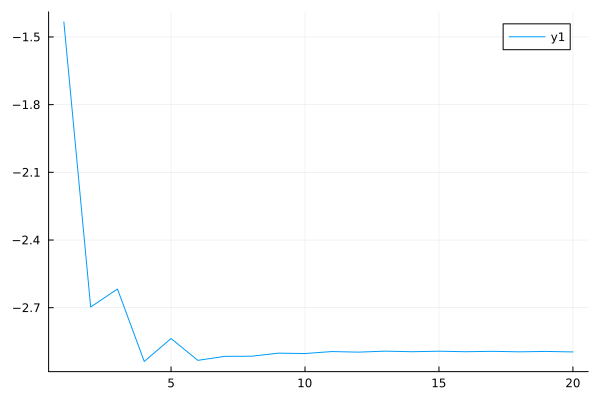

In [34]:
using Plots
plot(log10.(e))

In [ ]:
u1 = similar(r1)
r0 = FEM.nodePositionVector(problem)
for i in size(r1, 2)
    u1[:, i] = r1[:, i] .- r0[:]
end

u2 = FEM.showDoFResults(problem, u1, :uvec, t=1:size(u1, 2), visible=true)

3

In [14]:
r = FEM.nodePositionVector(problem)
ux(x, y, z) = 0.4x
uy(x, y, z) = 0.5y
uz(x, y, z) = 0.6z
q0 = FEM.field("body", fx=ux, fy=uy, fz=uz)
q = FEM.vectorField(problem, [q0])
F = FEM.deformationGradient(problem, q)

LowLevelFEM.TensorField([[0.3999999999999999; 0.0; … ; 0.0; 0.6000000000000001;;], [0.3999999999999999; 0.0; … ; 0.0; 0.6000000000000001;;], [0.3999999999999999; 0.0; … ; 0.0; 0.6000000000000001;;], [0.3999999999999999; 0.0; … ; 0.0; 0.6000000000000001;;], [0.3999999999999999; 0.0; … ; 0.0; 0.6000000000000001;;], [0.3999999999999999; 0.0; … ; 0.0; 0.6000000000000001;;], [0.3999999999999999; 0.0; … ; 0.0; 0.6000000000000001;;], [0.3999999999999999; 0.0; … ; 0.0; 0.6000000000000001;;], [0.3999999999999999; 0.0; … ; 0.0; 0.6000000000000001;;], [0.3999999999999999; 0.0; … ; 0.0; 0.6000000000000001;;]  …  [0.3999999999999999; 0.0; … ; 0.0; 0.6000000000000001;;], [0.3999999999999999; 0.0; … ; 0.0; 0.6000000000000001;;], [0.3999999999999999; 0.0; … ; 0.0; 0.6000000000000001;;], [0.3999999999999999; 0.0; … ; 0.0; 0.6000000000000001;;], [0.3999999999999999; 0.0; … ; 0.0; 0.6000000000000001;;], [0.3999999999999999; 0.0; … ; 0.0; 0.6000000000000001;;], [0.3999999999999999; 0.0; … ; 0.0; 0.6000000

In [15]:
reshape(F.A[1][1:9], 3, 3)

3×3 Matrix{Float64}:
 0.4  0.0  0.0
 0.0  0.5  0.0
 0.0  0.0  0.6

In [16]:
E = (F' * F - FEM.unitTensor(F)) / 2

reshape(E.A[1][1:9], 3, 3)

MethodError: MethodError: no method matching LowLevelFEM.TensorField(::Vector{Any}, ::Vector{Int64}, ::Int64, ::Symbol)
The type `LowLevelFEM.TensorField` exists, but no method is defined for this combination of argument types when trying to construct it.

Closest candidates are:
  LowLevelFEM.TensorField(::Any, ::Any, ::Any, ::Any, !Matched::Any)
   @ LowLevelFEM ~/Dokumentumok/GitHub/LowLevelFEM.jl/src/general.jl:402
  LowLevelFEM.TensorField(!Matched::Vector{Matrix{Float64}}, !Matched::Matrix{Float64}, !Matched::Vector{Int64}, !Matched::Int64, !Matched::Symbol)
   @ LowLevelFEM ~/Dokumentumok/GitHub/LowLevelFEM.jl/src/general.jl:402


In [17]:
e = (FEM.unitTensor(F) - inv(F * F')) / 2

reshape(e.A[1][1:9], 3, 3)

MethodError: MethodError: no method matching LowLevelFEM.TensorField(::Vector{Any}, ::Vector{Int64}, ::Int64, ::Symbol)
The type `LowLevelFEM.TensorField` exists, but no method is defined for this combination of argument types when trying to construct it.

Closest candidates are:
  LowLevelFEM.TensorField(::Any, ::Any, ::Any, ::Any, !Matched::Any)
   @ LowLevelFEM ~/Dokumentumok/GitHub/LowLevelFEM.jl/src/general.jl:402
  LowLevelFEM.TensorField(!Matched::Vector{Matrix{Float64}}, !Matched::Matrix{Float64}, !Matched::Vector{Int64}, !Matched::Int64, !Matched::Symbol)
   @ LowLevelFEM ~/Dokumentumok/GitHub/LowLevelFEM.jl/src/general.jl:402


In [18]:
e = inv(F') * E * inv(F)

reshape(e.A[1][1:9], 3, 3)

MethodError: MethodError: no method matching LowLevelFEM.TensorField(::Vector{Any}, ::Vector{Int64}, ::Int64, ::Symbol)
The type `LowLevelFEM.TensorField` exists, but no method is defined for this combination of argument types when trying to construct it.

Closest candidates are:
  LowLevelFEM.TensorField(::Any, ::Any, ::Any, ::Any, !Matched::Any)
   @ LowLevelFEM ~/Dokumentumok/GitHub/LowLevelFEM.jl/src/general.jl:402
  LowLevelFEM.TensorField(!Matched::Vector{Matrix{Float64}}, !Matched::Matrix{Float64}, !Matched::Vector{Int64}, !Matched::Int64, !Matched::Symbol)
   @ LowLevelFEM ~/Dokumentumok/GitHub/LowLevelFEM.jl/src/general.jl:402


In [19]:
U = sqrt(F' * F)

reshape(U.A[1][1:9], 3, 3)

MethodError: MethodError: no method matching LowLevelFEM.TensorField(::Vector{Any}, ::Vector{Int64}, ::Int64, ::Symbol)
The type `LowLevelFEM.TensorField` exists, but no method is defined for this combination of argument types when trying to construct it.

Closest candidates are:
  LowLevelFEM.TensorField(::Any, ::Any, ::Any, ::Any, !Matched::Any)
   @ LowLevelFEM ~/Dokumentumok/GitHub/LowLevelFEM.jl/src/general.jl:402
  LowLevelFEM.TensorField(!Matched::Vector{Matrix{Float64}}, !Matched::Matrix{Float64}, !Matched::Vector{Int64}, !Matched::Int64, !Matched::Symbol)
   @ LowLevelFEM ~/Dokumentumok/GitHub/LowLevelFEM.jl/src/general.jl:402


In [20]:
Ex = 10
νxy = 0.3
λ = Ex * νxy / ((1 + νxy) * (1 - 2νxy))
μ = Ex / (2 * (1 + νxy))
I3 = FEM.unitTensor(F)
iC = inv(F' * F)
J1 = det(F)
SII = μ * (I3 - iC) + λ * log(J1) / J1 * I3

reshape(SII.A[1][1:9], 3, 3)

MethodError: MethodError: no method matching LowLevelFEM.TensorField(::Vector{Any}, ::Vector{Int64}, ::Int64, ::Symbol)
The type `LowLevelFEM.TensorField` exists, but no method is defined for this combination of argument types when trying to construct it.

Closest candidates are:
  LowLevelFEM.TensorField(::Any, ::Any, ::Any, ::Any, !Matched::Any)
   @ LowLevelFEM ~/Dokumentumok/GitHub/LowLevelFEM.jl/src/general.jl:402
  LowLevelFEM.TensorField(!Matched::Vector{Matrix{Float64}}, !Matched::Matrix{Float64}, !Matched::Vector{Int64}, !Matched::Int64, !Matched::Symbol)
   @ LowLevelFEM ~/Dokumentumok/GitHub/LowLevelFEM.jl/src/general.jl:402


In [21]:
function probe(A, x, y, z)
    elementTag, elementType, nodeTags, u, v, w = gmsh.model.mesh.getElementByCoordinates(x, y, z, 3, false)
    elementName, dim, order, numNodes::Int64, localNodeCoord, numPrimaryNodes = gmsh.model.mesh.getElementProperties(elementType)
    comp, fun, ori = gmsh.model.mesh.getBasisFunctions(elementType, [u, v, w], "Lagrange")
    SS = [0.0, 0, 0, 0, 0, 0, 0, 0, 0]
    if isa(A, FEM.TensorField)
        ind = findfirst(i -> i == elementTag, SII.numElem)
        for i in range(1, 9)
            SS[i] = fun' * SII.A[ind][i:9:9numNodes, 1]
        end
    elseif isa(A, Matrix)
        for i in range(1, 9)
            SS[i] = fun' * A[9nodeTags.-(9-i), 1]
        end
    end
    return reshape(SS, 3, 3)
end

probe (generic function with 1 method)

In [22]:
SII2 = FEM.elementsToNodes(problem, SII)

UndefVarError: UndefVarError: `SII` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [23]:
probe(SII2, 0, 0, 0)

UndefVarError: UndefVarError: `SII2` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [24]:
field = FEM.field("body", f=2)
sc = FEM.ScalarField(problem, [field])

LowLevelFEM.ScalarField([[2.0; 2.0; … ; 2.0; 2.0;;], [2.0; 2.0; … ; 2.0; 2.0;;], [2.0; 2.0; … ; 2.0; 2.0;;], [2.0; 2.0; … ; 2.0; 2.0;;], [2.0; 2.0; … ; 2.0; 2.0;;], [2.0; 2.0; … ; 2.0; 2.0;;], [2.0; 2.0; … ; 2.0; 2.0;;], [2.0; 2.0; … ; 2.0; 2.0;;], [2.0; 2.0; … ; 2.0; 2.0;;], [2.0; 2.0; … ; 2.0; 2.0;;]  …  [2.0; 2.0; … ; 2.0; 2.0;;], [2.0; 2.0; … ; 2.0; 2.0;;], [2.0; 2.0; … ; 2.0; 2.0;;], [2.0; 2.0; … ; 2.0; 2.0;;], [2.0; 2.0; … ; 2.0; 2.0;;], [2.0; 2.0; … ; 2.0; 2.0;;], [2.0; 2.0; … ; 2.0; 2.0;;], [2.0; 2.0; … ; 2.0; 2.0;;], [2.0; 2.0; … ; 2.0; 2.0;;], [2.0; 2.0; … ; 2.0; 2.0;;]], Matrix{Float64}(undef, 0, 0), [273, 274, 275, 276, 277, 278, 279, 280, 281, 282  …  423, 424, 425, 426, 427, 428, 429, 430, 431, 432], 1, :scalarInElements)

In [25]:
I3 = FEM.unitTensor(F)
J = det(F)

MethodError: MethodError: no method matching LowLevelFEM.TensorField(::Vector{Any}, ::Vector{Int64}, ::Int64, ::Symbol)
The type `LowLevelFEM.TensorField` exists, but no method is defined for this combination of argument types when trying to construct it.

Closest candidates are:
  LowLevelFEM.TensorField(::Any, ::Any, ::Any, ::Any, !Matched::Any)
   @ LowLevelFEM ~/Dokumentumok/GitHub/LowLevelFEM.jl/src/general.jl:402
  LowLevelFEM.TensorField(!Matched::Vector{Matrix{Float64}}, !Matched::Matrix{Float64}, !Matched::Vector{Int64}, !Matched::Int64, !Matched::Symbol)
   @ LowLevelFEM ~/Dokumentumok/GitHub/LowLevelFEM.jl/src/general.jl:402


In [26]:
sc * I3

UndefVarError: UndefVarError: `I3` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [27]:
I3 - I3

UndefVarError: UndefVarError: `I3` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [28]:
σ = F * SII * F' / det(F)

reshape(σ.A[1][1:9], 3, 3)

UndefVarError: UndefVarError: `SII` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [29]:
J = 0.5 * 0.5 * 0.5
μ / J * (J^(2 / 3) - 1) + λ / J * log(J)

-119.05114807753088

In [30]:
FEM.openPostProcessor()

-------------------------------------------------------
Version       : 4.13.1
License       : GNU General Public License
Build OS      : Linux64-sdk
Build date    : 19700101
Build host    : amdci7.julia.csail.mit.edu
Build options : 64Bit ALGLIB[contrib] ANN[contrib] Bamg Blossom Cairo DIntegration Dlopen DomHex Eigen[contrib] Fltk GMP Gmm[contrib] Hxt Jpeg Kbipack LinuxJoystick MathEx[contrib] Mesh Metis[contrib] Mmg Mpeg Netgen Nii2mesh ONELAB ONELABMetamodel OpenCASCADE OpenCASCADE-CAF OpenGL OpenMP OptHom Parser Plugins Png Post QuadMeshingTools QuadTri Solver TetGen/BR TinyXML2[contrib] Untangle Voro++[contrib] WinslowUntangler Zlib
FLTK version  : 1.3.8
OCC version   : 7.7.2
Packaged by   : root
Web site      : https://gmsh.info
Issue tracker : https://gitlab.onelab.info/gmsh/gmsh/issues
-------------------------------------------------------


XOpenIM() failed
XRequest.18: BadValue 0x0


In [31]:
gmsh.finalize()